Let \\(y_t\\) denote observation \\(t\\) in a real-valued time series. A structural time series model can be described by a pair of equations relating yt to a vector of latent state variables $u_t$

$$ y_t = Z^T_tu_{t} + \varepsilon_t$$

$$ u_T = Tu_{t_1} + R\eta_t $$

Where \\( \varepsilon_t \sim N\left(0, H_t\right) \\) and \\( \eta_t \sim N\left(0, Q_t\right) \\).

One usefuel extension of thsi model is the 'basic' structural time series, which can be described in the following equations:

$$ y_t = u_{t} + \tau_t + \beta^T\textbf{x} + \varepsilon_t$$

$$ u_T = u_{t_1} + \delta_{t-1} + \eta_t $$

$$ \delta_t = \delta_{t-1} + \nu_t $$

$$ \tau_t = -\sum_{s=1}^{S-1} \tau_{t-s} + w_t $$

We'll model this in sections, firsly by excluding the seasonal component.

In [1]:
import pystan
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')
%matplotlib inline

stan_code = """data {
  int <lower=0> T;
  vector[T] x;
  vector[T] y;
}

parameters {
  vector[T] u_err; //Slope innovation
  vector[T] v_err; //Level innovation
  real beta;
  real <lower=0> s_obs;
  real <lower=0> s_slope;
  real <lower=0> s_level;
}

transformed parameters {
  vector[T] u; //Level
  vector[T] v; //Slope
  u[1] = u_err[1];
  v[1] = v_err[1];
  for (t in 2:T) {
    u[t] = u[t-1] + v[t-1] + s_level * u_err[t];
    v[t] = v[t-1] + s_slope * v_err[t];
  }
}

model {
  u_err ~ normal(0,1);
  v_err ~ normal(0,1);
  y ~ normal (u + beta*x, s_obs);
}"""

In [2]:
data = pd.read_csv('unemployment.csv')

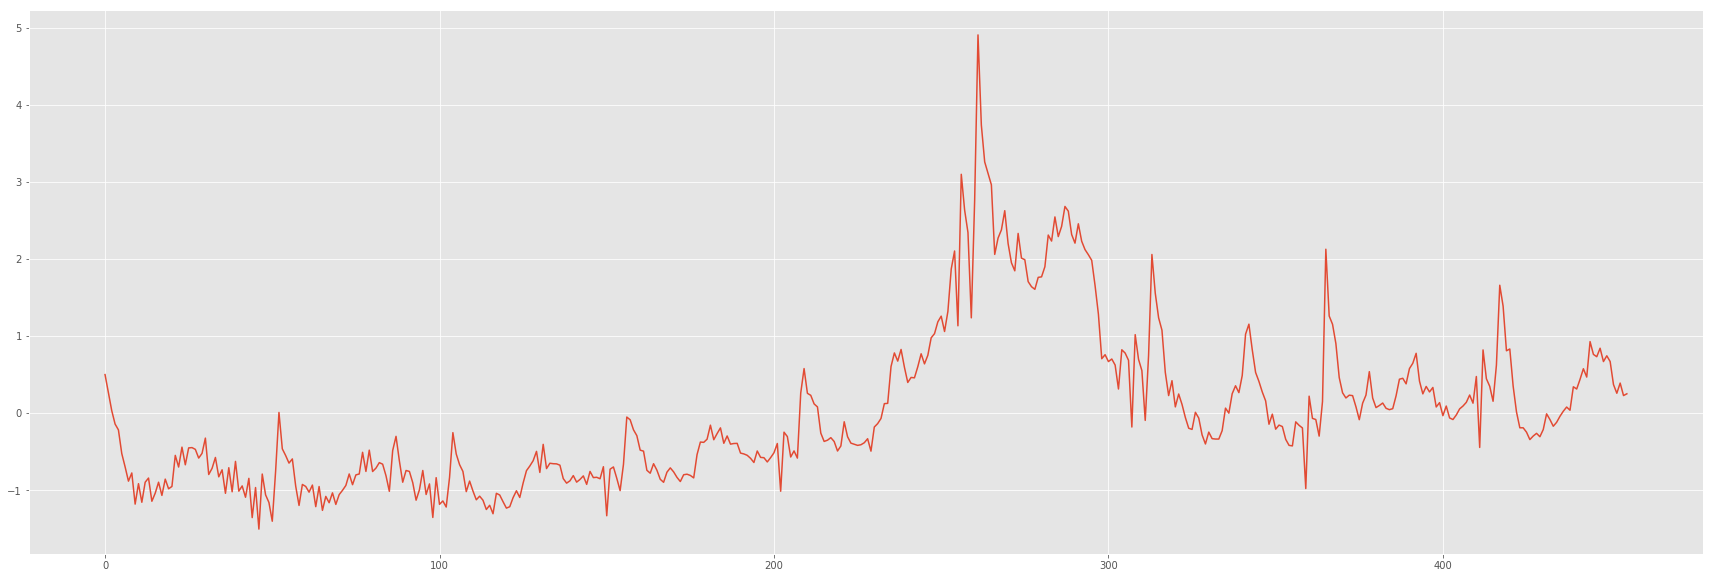

In [12]:
data['unemployment.office'].plot(figsize=(30, 10))

In [5]:
data_feed = {'y': data['unemployment.office'].values, 'x': np.zeros((data.shape[0], )), 'T': data.shape[0]}
sm = pystan.StanModel(model_code=stan_code)
fit = sm.sampling(data=data_feed, iter=1000)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a216d1830c917dccb932a956782a2c63 NOW.
/Users/thomas.kealy/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


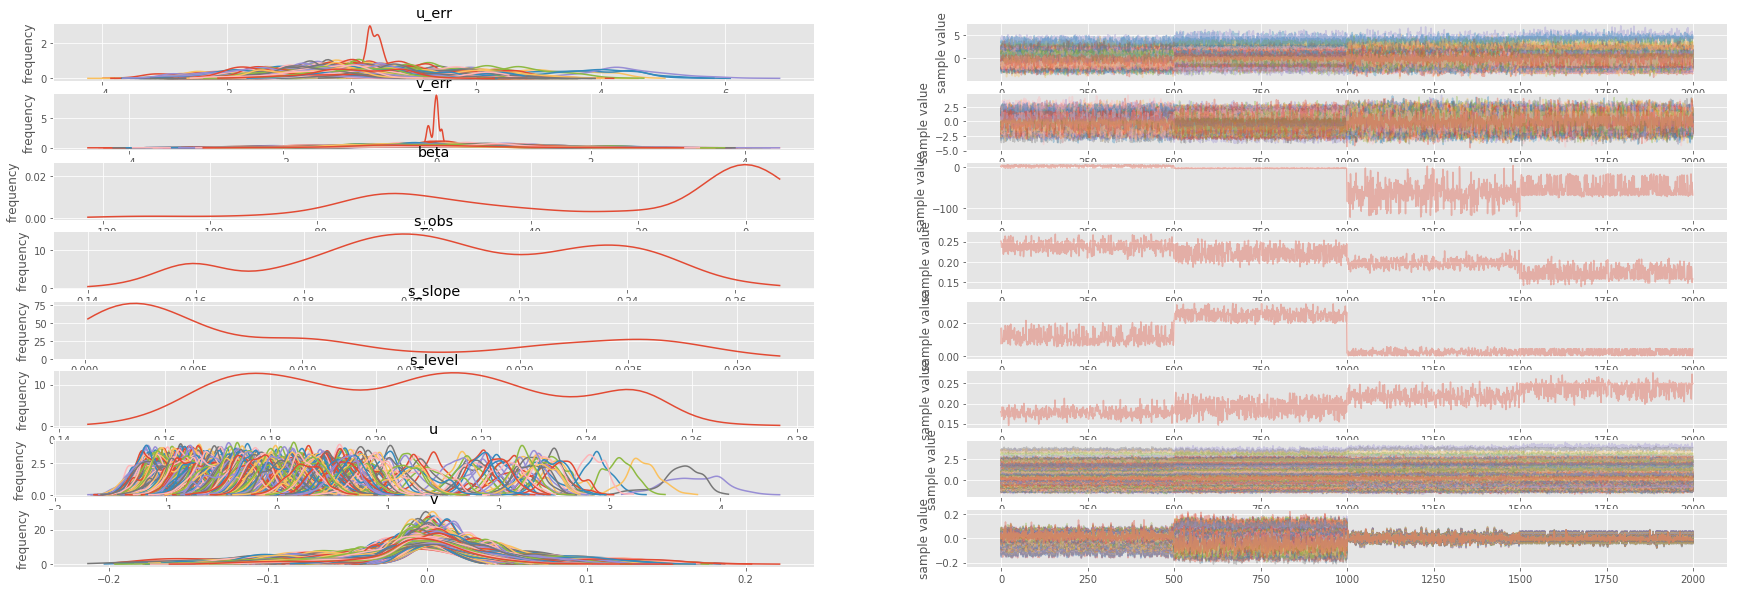

In [6]:
with mpl.rc_context():
    mpl.rc('figure', figsize=(30, 10))
    fit.plot()

In [7]:
samples = fit.extract(permuted=True)
u = samples['u'].mean(axis=0)
v = samples['v'].mean(axis=0)

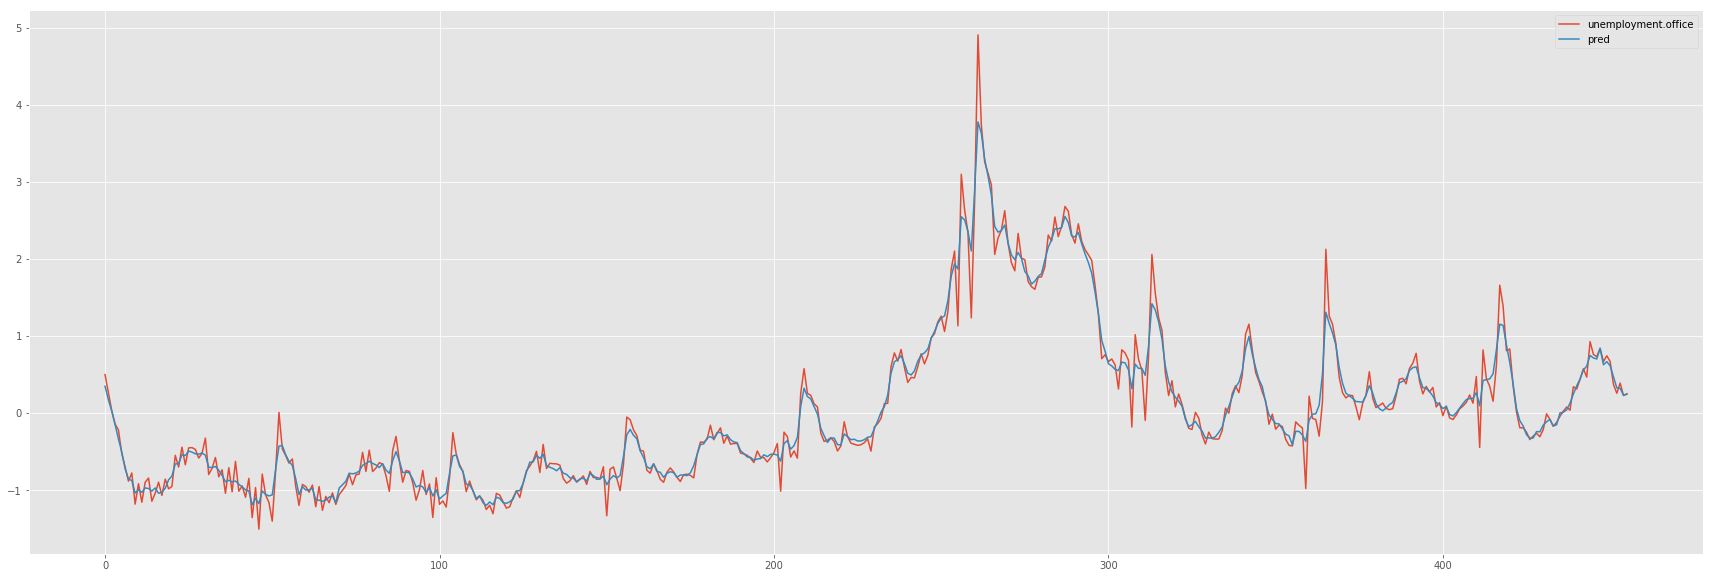

In [8]:
data['pred'] = u + v
data[['unemployment.office', 'pred']].plot(figsize=(30, 10))

The fit looks ok, but it can definately be improved by adding a seasonal component.